# Leios simulation analysis at tag `leios-2025w31`

## Set up

### Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

### Define utility functions

In [2]:
sort_factors <- function(fs, ascending=TRUE) {
    xs <- fs[as.numeric(sub(" .*$", "", fs)) %>% order]
    if (ascending)
        xs
    else
        rev(xs)
}

## Experiment: mini-mainnet vs pseudo-mainnet

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(lifecycle, sampleSize, file="results/lifecycle.R")
}
setnames(lifecycle, old="Kind", new="Message")
lifecycle[, `Stage length`:=factor(`Stage length`, levels=sort_factors(lifecycle[, unique(`Stage length`)]))]
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator                 Variant              Network         Bandwidth     
 Rust:241321   full-without-ibs:241321   topology-v2:241321   50 Mb/s:241321  
                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
                                                                              
        Stage length           EB rate         Max EB size    
 5 slot/stage :60467   2.5 EB/stage:241321   10 MB/EB:241321  
 8 slot/stage :60327                                          
 10 slot/stage:60267                                          
 12 slot/stage:60260                                          
                                                     

In [4]:
label <- lifecycle[, unique(paste(`Simulator`, `Variant`, `Network`, `Bandwidth`, `EB rate`, `Max EB size`, `Tx size`, `Throughput`, sep=", "))]

In [5]:
fixed <- c("Simulator", "Variant", "Network", "Bandwidth", "EB rate", "Max EB size", "Tx size", "Throughput")

In [6]:
varied <- c("Stage length")

In [7]:
facet_varied <- function(scales="free_y", wide=FALSE) {
    if (wide)
        facet_grid(. ~ `Stage length`, scales=scales)
    else
        facet_grid(`Stage length` ~ ., scales=scales)
}

#### Range of transaction injection

In [8]:
txFirst <- lifecycle[, median(`Tx start [s]`)]
txLast <- lifecycle[, median(`Tx stop [s]`)]
txWindow <- txLast - txFirst
simFinish <- lifecycle[, median(`Sim stop [s]`)]

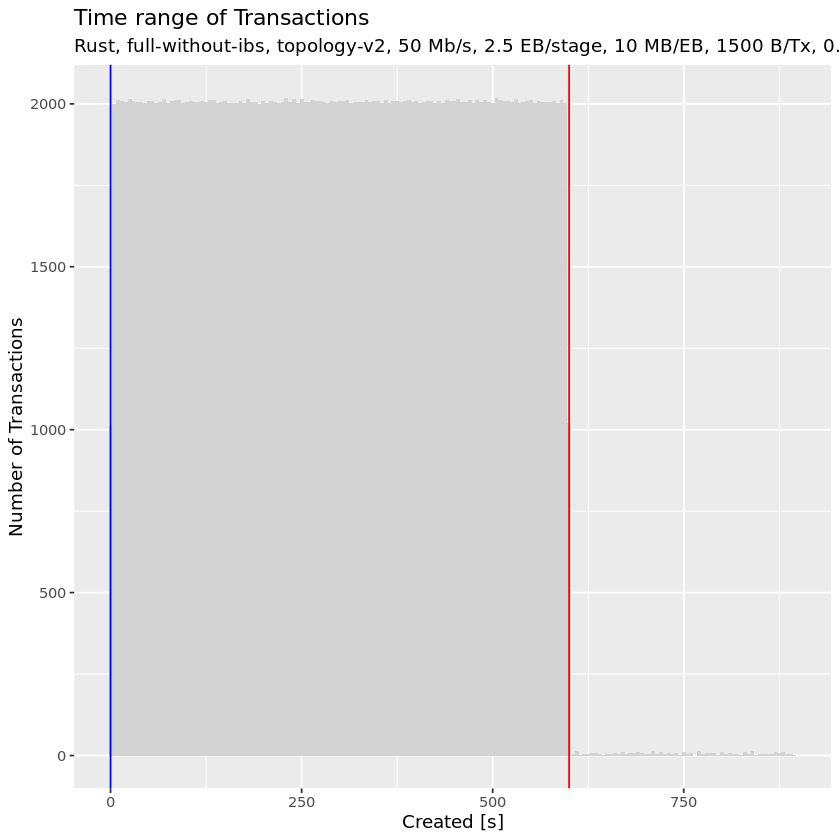

In [9]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions", label)

#### Actual TPS

In [10]:
dtmp <- lifecycle[
    `Message` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow
    ),
    c(fixed, varied)
]
setorderv(dtmp, varied)
dtmp

Simulator,Variant,Network,Bandwidth,EB rate,Max EB size,Tx size,Throughput,Stage length,Demand [tx/s]
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
Rust,full-without-ibs,topology-v2,50 Mb/s,2.5 EB/stage,10 MB/EB,1500 B/Tx,0.150 TxMB/s,5 slot/stage,100.0017
Rust,full-without-ibs,topology-v2,50 Mb/s,2.5 EB/stage,10 MB/EB,1500 B/Tx,0.150 TxMB/s,8 slot/stage,100.0017
Rust,full-without-ibs,topology-v2,50 Mb/s,2.5 EB/stage,10 MB/EB,1500 B/Tx,0.150 TxMB/s,10 slot/stage,100.0017
Rust,full-without-ibs,topology-v2,50 Mb/s,2.5 EB/stage,10 MB/EB,1500 B/Tx,0.150 TxMB/s,12 slot/stage,100.0017


#### Size of persisted data

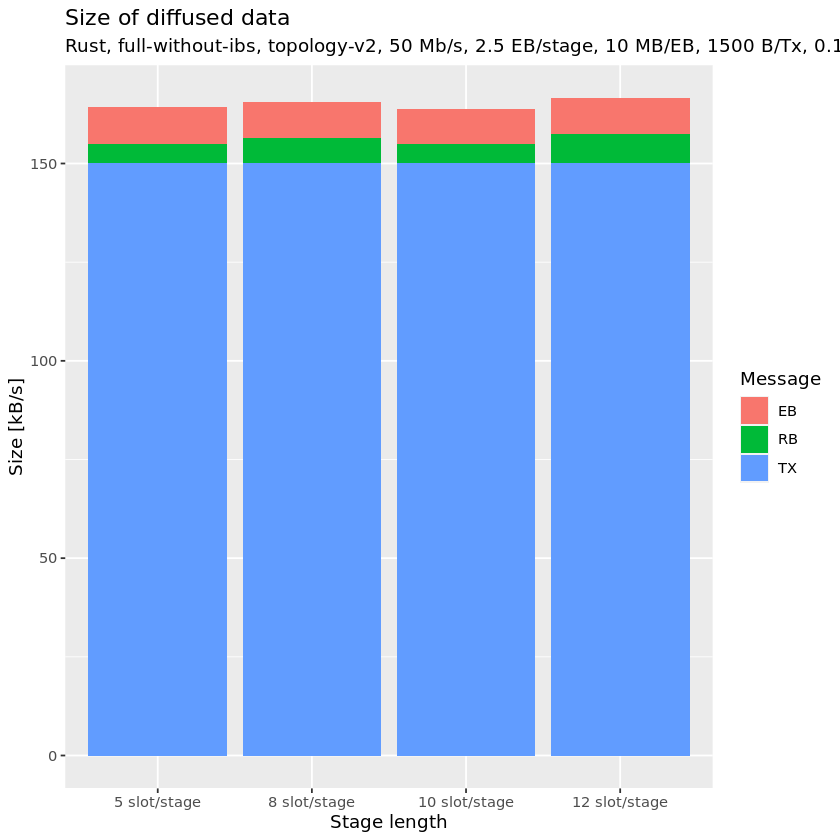

In [11]:
ggplot(
    lifecycle[,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        c(varied, "Message")
    ],
    aes(x=!!sym(varied), y=`Size [kB/s]`, fill=`Message`)
) + geom_bar(stat="identity") +
    ggtitle("Size of diffused data", subtitle=label)

In [12]:
ggsave("plots/sizes.png", units="in", dpi=150, width=16, height=8)

#### Spatial efficiency

In [13]:
dtmp <- lifecycle[
        `Message` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        varied
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric((`Variant` != "linear" & `Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            varied
        ],
        on=varied
    ][, .(`Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`), varied]
setorderv(dtmp, varied)
dtmp

Stage length,Space efficiency [%]
<fct>,<dbl>
5 slot/stage,91.18421
8 slot/stage,90.54826
10 slot/stage,91.53749
12 slot/stage,89.98870


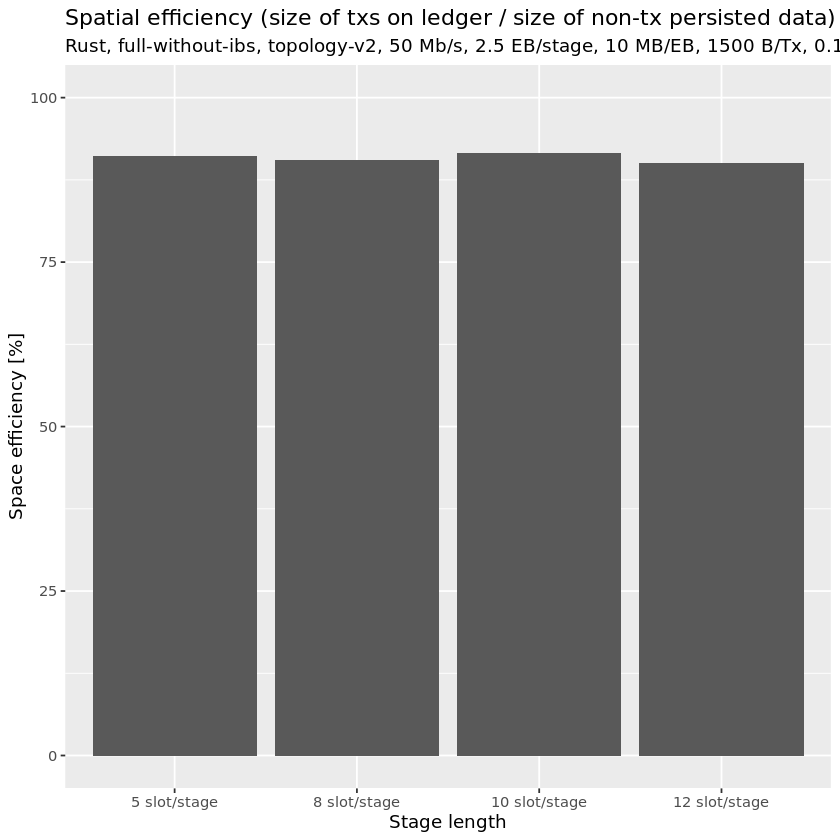

In [14]:
ggplot(
    lifecycle[
        `Message` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        varied
    ][
        lifecycle[
            `Message` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric((`Variant` != "linear" & `Message` == "TX" | `Message` == "EB" | `Message` == "RB") * `Size [B]`))), 
            varied
        ],
        on=varied
    ][, .(`Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`), varied],
    aes(x=!!sym(varied), y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ylim(0, 100) +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [15]:
ggsave("plots/spatial-efficiency.png", units="in", dpi=150, width=16, height=8)

#### Time to reach the EB

In [16]:
dtmp <- lifecycle[
        `Message` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=mean(`To EB [s]`-`Created [s]`)), 
        varied
    ]
setorderv(dtmp, varied)
dtmp

Stage length,Time to reach EB [s]
<fct>,<dbl>
5 slot/stage,3.069357
8 slot/stage,4.550983
10 slot/stage,6.064222
12 slot/stage,6.480281


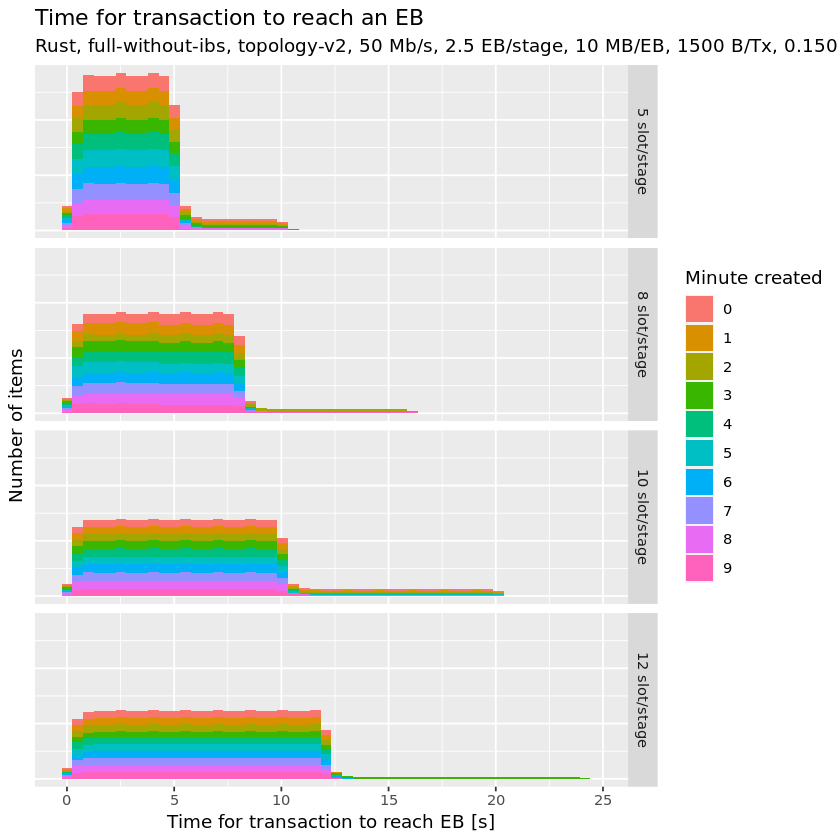

In [17]:
ggplot(
    substitute(
        lifecycle[
            `Message` == "TX" & 
            !is.na(`To EB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
            .(`Varied`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
    facet_grid(`Stage length` ~ .) +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach an EB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [18]:
ggsave("plots/reach-eb-tx.png", units="in", dpi=150, width=16, height=8)

#### Time to reach the ledger

In [19]:
dtmp <- lifecycle[
        `Message` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`To RB [s]`-`Created [s]`)), 
        varied
    ]
setorderv(dtmp, varied)
dtmp

Stage length,Time to reach ledger [s]
<fct>,<dbl>
5 slot/stage,88.95128
8 slot/stage,83.35994
10 slot/stage,85.44222
12 slot/stage,67.83764


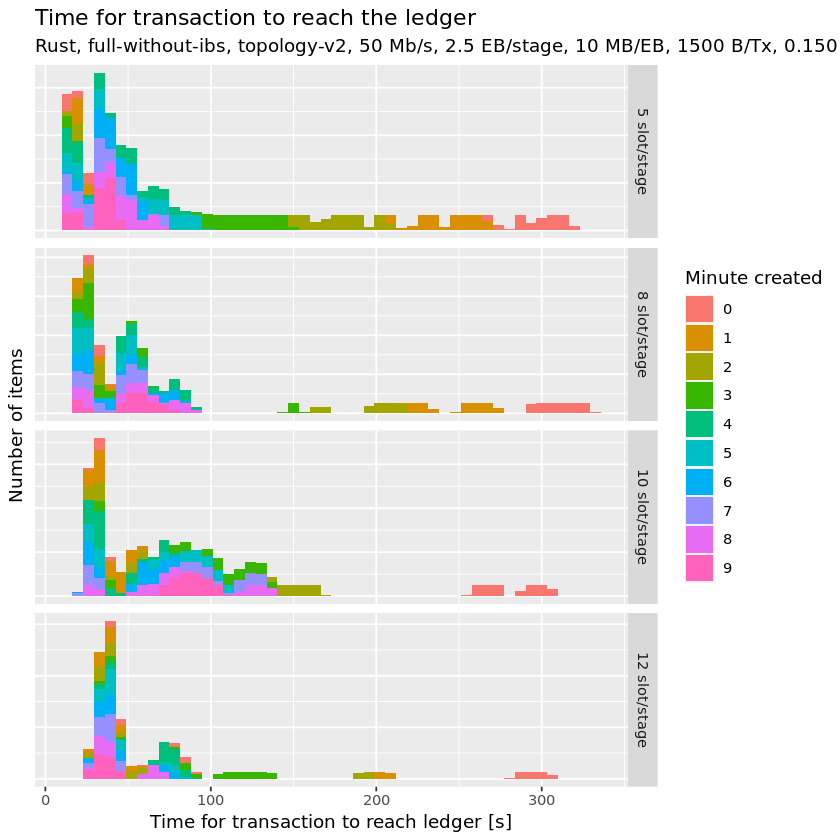

In [20]:
ggplot(
    substitute(
        lifecycle[
            `Message` == "TX" & 
            !is.na(`To RB [s]`) &
            `Created [s]` >= txFirst & `Created [s]` < txLast, 
            .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
            .(`Varied`, `Minute created`=factor(floor(`Created [s]`/60)))
        ],
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
    facet_varied() +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [21]:
ggsave("plots/reach-rb-tx.png", units="in", dpi=150, width=16, height=8)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

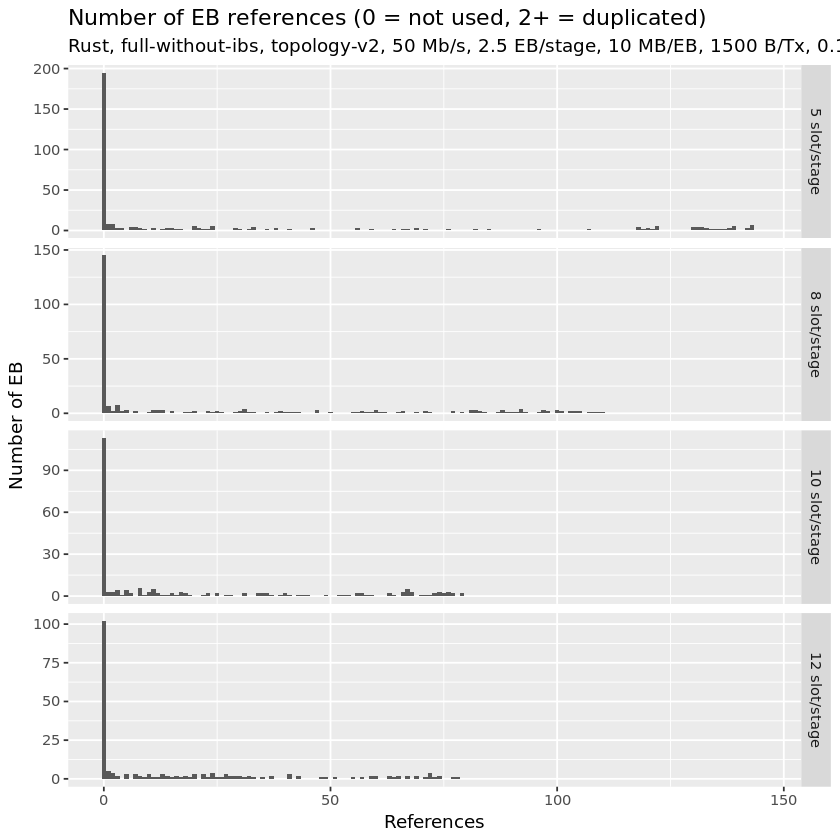

In [22]:
ggplot(
    lifecycle[
        `Message` == "EB",
        .(`References`),
        varied
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_varied() +
#   scale_x_sqrt() +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)", label)

In [23]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=16, height=8)

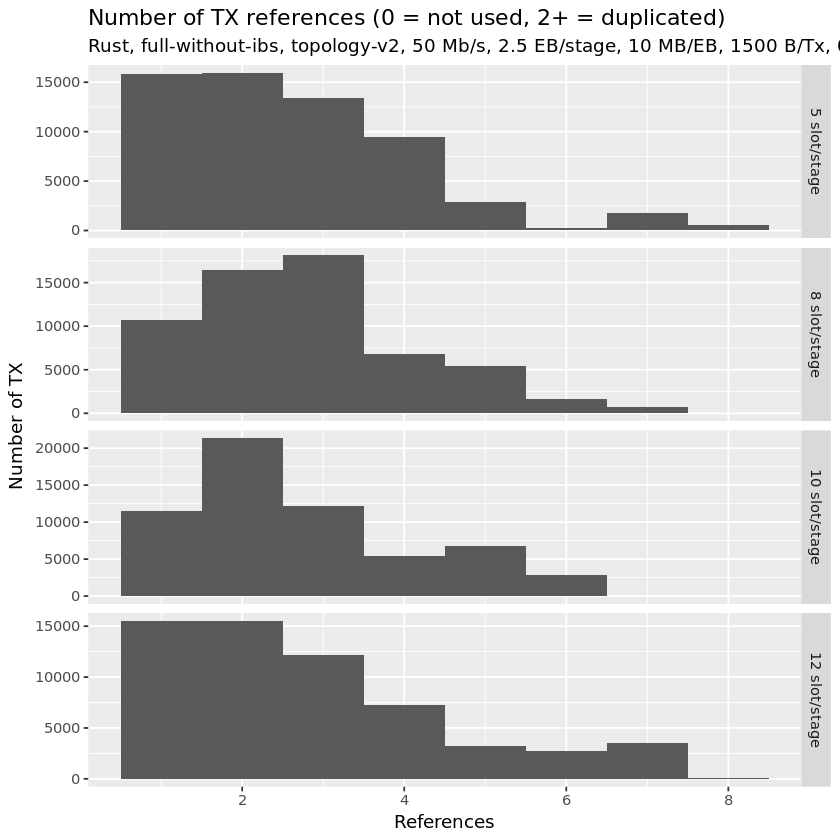

In [24]:
ggplot(
    lifecycle[
        `Message` == "TX",
        .(`References`),
        varied
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_varied() +
    ylab("Number of TX") +
    ggtitle("Number of TX references (0 = not used, 2+ = duplicated)", label)

In [25]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=16, height=8)

#### Temporal efficiency

In [26]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [27]:
outcomes <- lifecycle[
    `Message` == "TX",
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ),
    varied
]

In [28]:
totals <- substitute(
    outcomes[
        , 
        .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), 
        .(`Varied`, `Submitted [minute]`)
    ],
    env=list(`Varied`=sym(varied))
) %>% eval

#### Transactions reaching the ledger

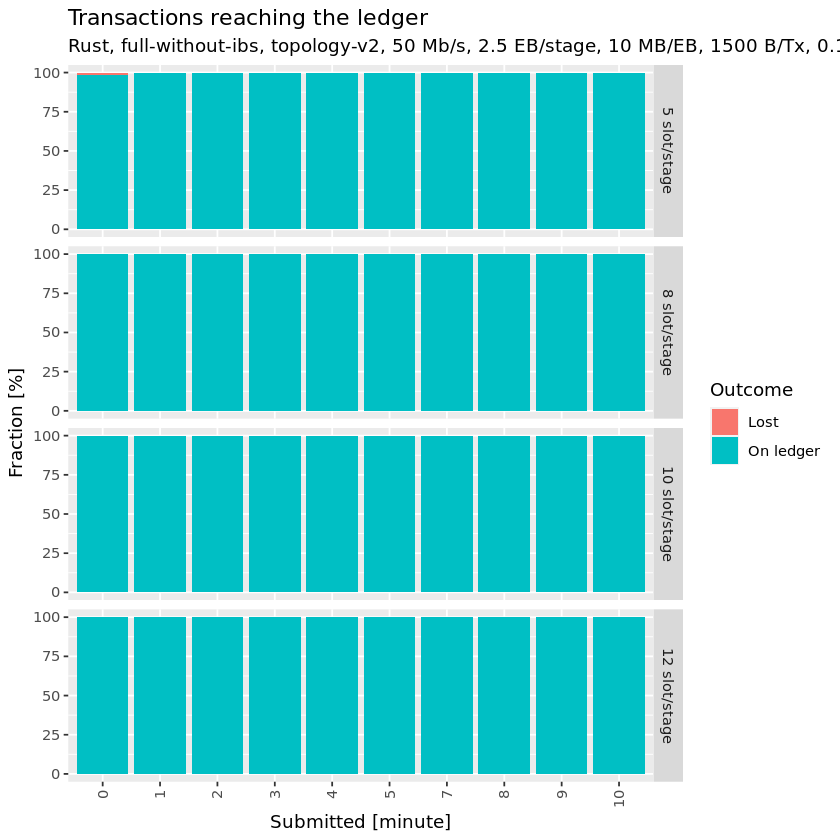

In [29]:
ggplot(
    substitute(
        melt(
            totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Varied`, `Submitted [minute]`)],
            id.vars=c(varied, "Submitted [minute]"),
            variable.name="Outcome",
            value.name="Fraction"
        )[`Submitted [minute]` != 6, .(
            `Varied`,
            `Submitted [minute]`, 
            `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
            `Fraction [%]`=100*`Fraction`
        )],
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_varied() +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [30]:
ggsave("plots/temporal-efficiency-bar.png", units="in", dpi=150, width=16, height=8)

#### Release memory

In [31]:
rm(lifecycle, outcomes, totals)

In [32]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,963638,51.5,2158730,115.3,2158730,115.3
Vcells,1777581,13.6,10051748,76.7,12564684,95.9


### Resource usage

In [33]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(resources, file="results/resources.Rdata")
}
resources[, `Stage length`:=factor(`Stage length`, levels=sort_factors(resources[, unique(`Stage length`)]))]
resources %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator               Variant            Network       Bandwidth   
 Rust:3000   full-without-ibs:3000   topology-v2:3000   50 Mb/s:3000  
                                                                      
                                                                      
                                                                      
                                                                      
                                                                      
                                                                      
        Stage length         EB rate       Max EB size        Tx size    
 5 slot/stage :750   2.5 EB/stage:3000   10 MB/EB:3000   1500 B/Tx:3000  
 8 slot/stage :750                                                       
 10 slot/stage:750                                                       
 12 slot/stage:750                                                       
                                                              

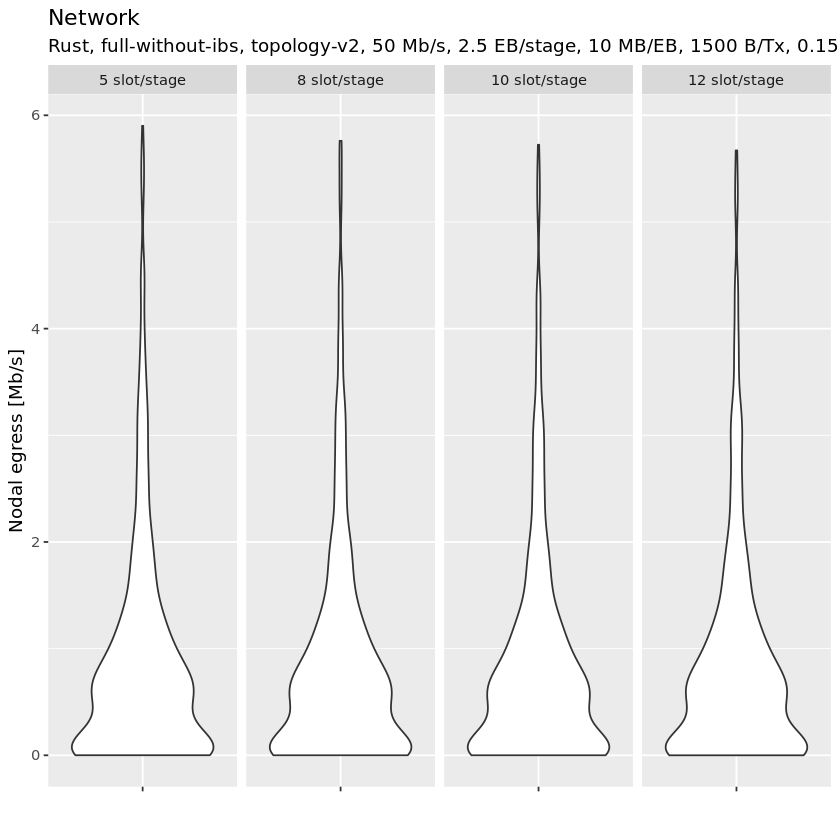

In [34]:
ggplot(
    substitute(
        resources[, .(`Varied`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_varied(wide=TRUE) +
    xlab("") +
    ggtitle("Network", label)

In [35]:
ggsave("plots/network.png", units="in", dpi=150, width=16, height=8)

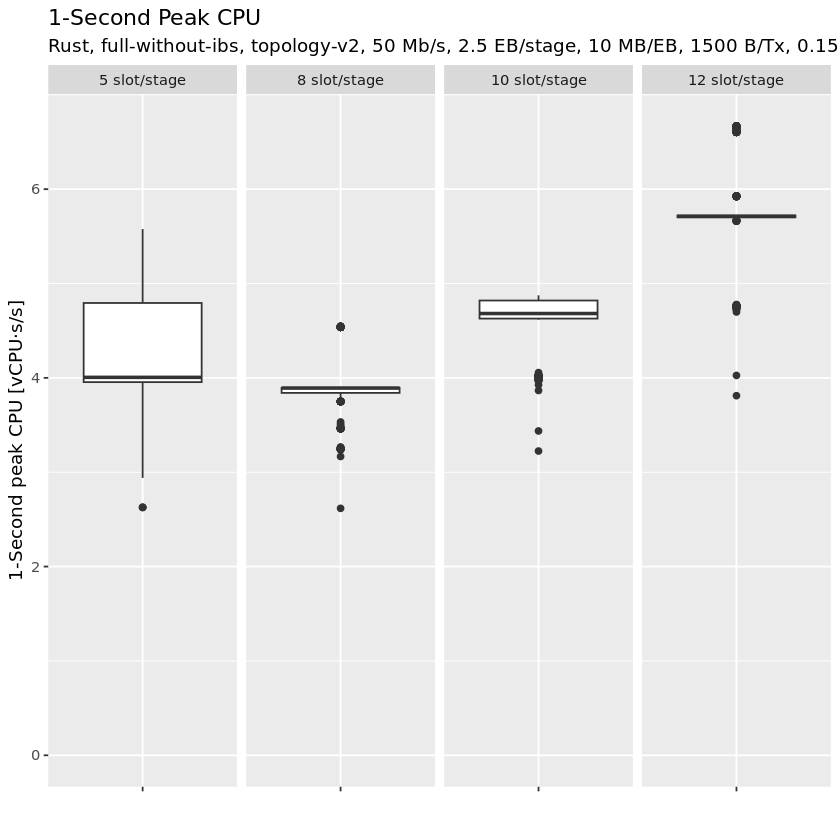

In [36]:
ggplot(
    substitute(
        resources[, .(`Varied`, `Node`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied(wide=TRUE) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [37]:
ggsave("plots/cpu-peak.png", units="in", dpi=150, width=16, height=8)

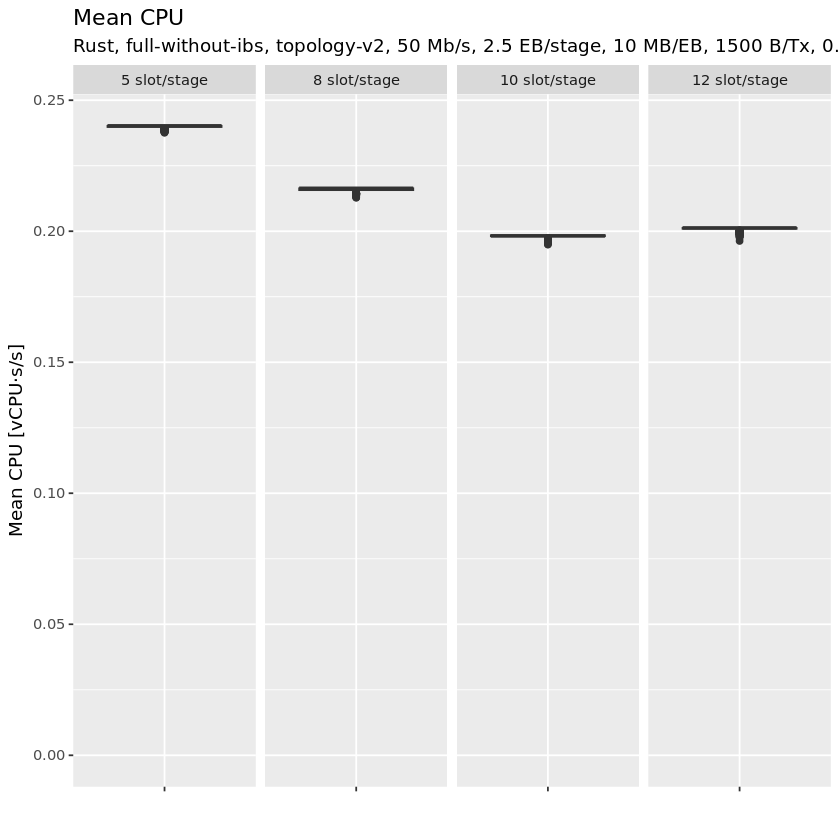

In [38]:
ggplot(
    substitute(
        resources[, .(`Varied`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish)], 
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_varied(wide=TRUE) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [39]:
ggsave("plots/cpu-mean.png", units="in", dpi=150, width=16, height=8)

#### Release memory

In [40]:
rm(resources)

In [41]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,993674,53.1,2158730,115.3,2158730,115.3
Vcells,1826213,14.0,10051748,76.7,12564684,95.9


### Receipt of messages

#### Read results

In [42]:
if (file.exists("results/receipts.Rdata")) {
    load("results/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(receipts, file="results/receipts.Rdata")
}
setnames(receipts, old="Kind", new="Message")
receipts[, `Stage length`:=factor(`Stage length`, levels=sort_factors(receipts[, unique(`Stage length`)]))]
receipts %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator                    Variant                 Network         
 Rust:240511349   full-without-ibs:240511349   topology-v2:240511349  
                                                                      
                                                                      
                                                                      
                                                                      
                                                                      
                                                                      
   Bandwidth                Stage length              EB rate         
 50 Mb/s:240511349   5 slot/stage :68559466   2.5 EB/stage:240511349  
                     8 slot/stage :60170984                           
                     10 slot/stage:56677919                           
                     12 slot/stage:55102980                           
                                                                      
      

In [43]:
kinds <- receipts[, unique(`Message`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [44]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            rs[, .(`Varied`, `Network`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_varied(scales=scales) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

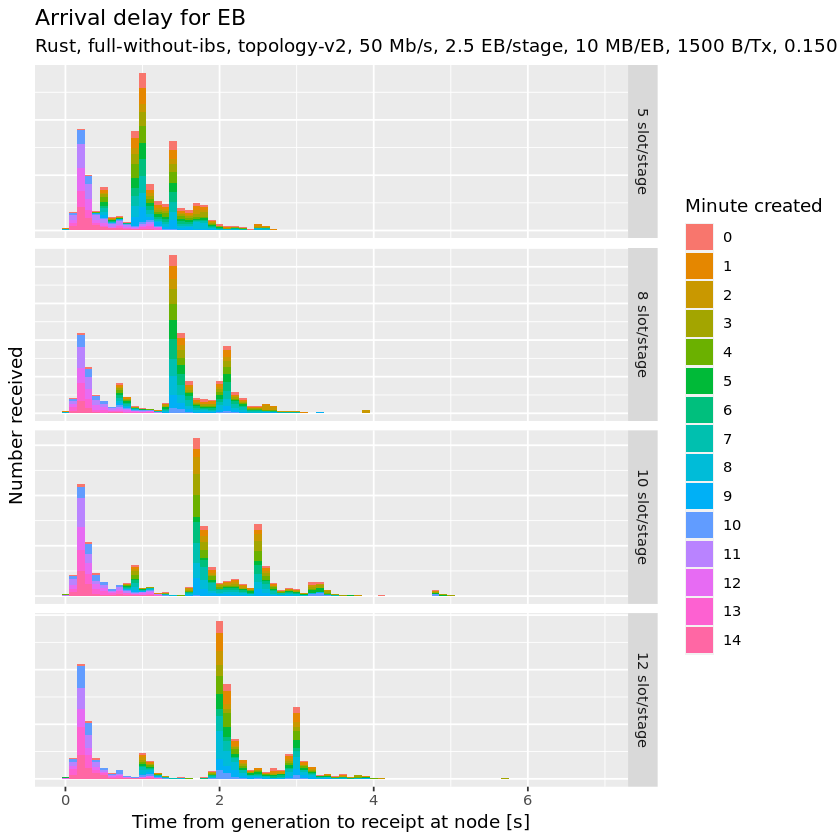

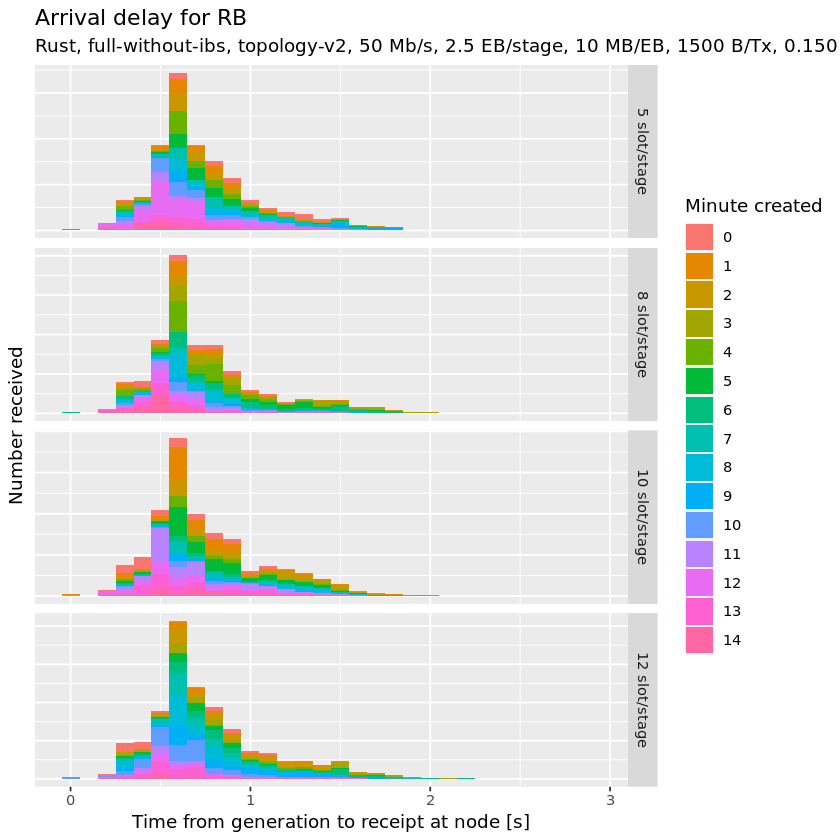

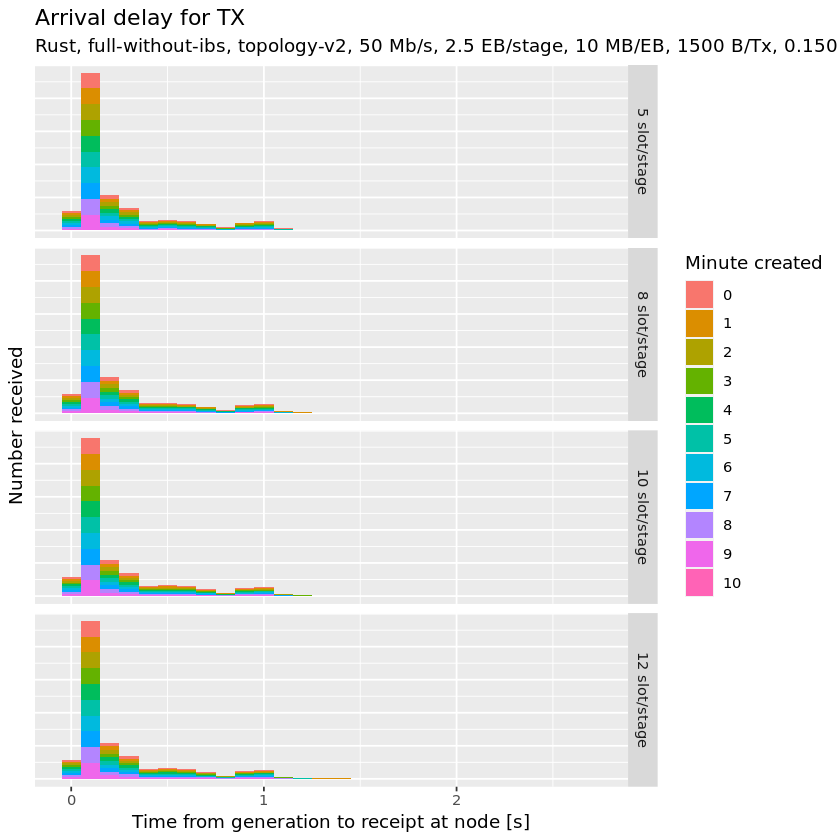

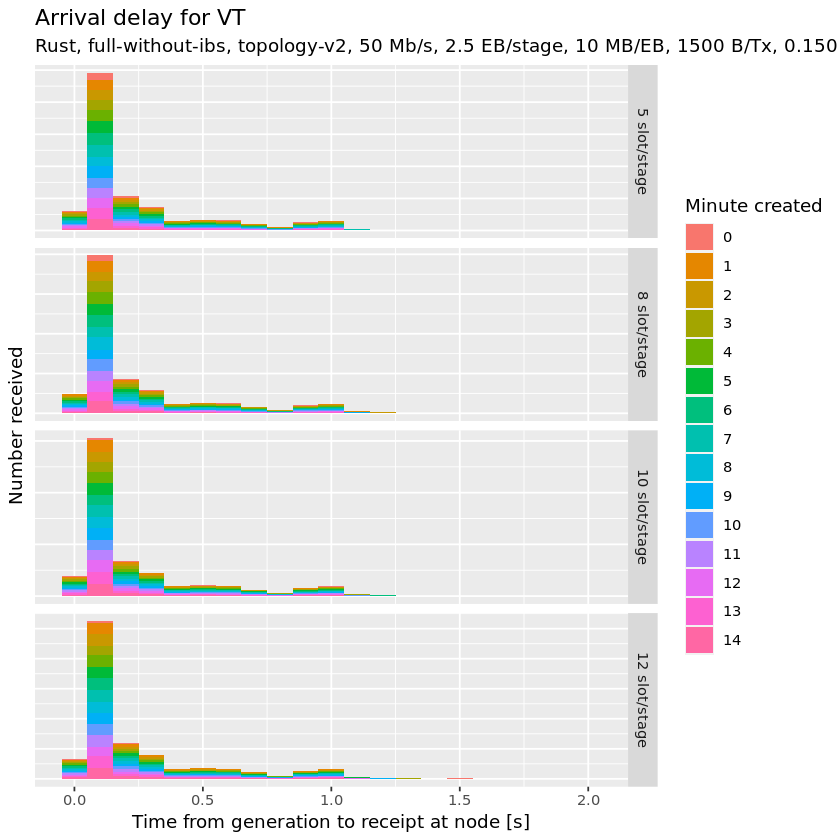

In [45]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Message` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/elapsed-", k, ".png")
    ) %>% print

#### Bandwidth usagefacet_varied

##### Total network bandwidth

In [46]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            rs[,
                .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
                by=.(`Varied`, `Network`, `Slot`=floor(`Received [s]`), `Message`)
            ],
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_varied(scales=scales) +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

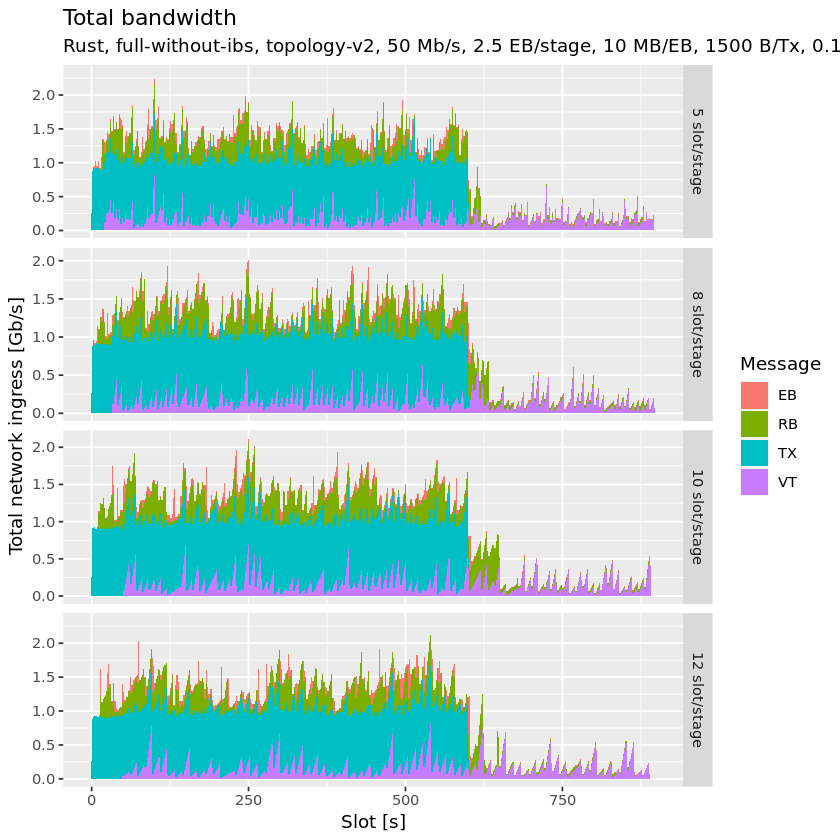

In [47]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="free_y",
    outfiles=paste0("plots/ingress-total-area.png")
)

##### Bandwidth usage per node

In [48]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [49]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            rs[,
                .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6/ifelse(`Network`=="topology-v1",10000,750)/sampleSize),
                by=.(`Varied`, `Network`, `Slot`=floor(`Received [s]`), `Message`)
            ],
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_varied(scales=scales) +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

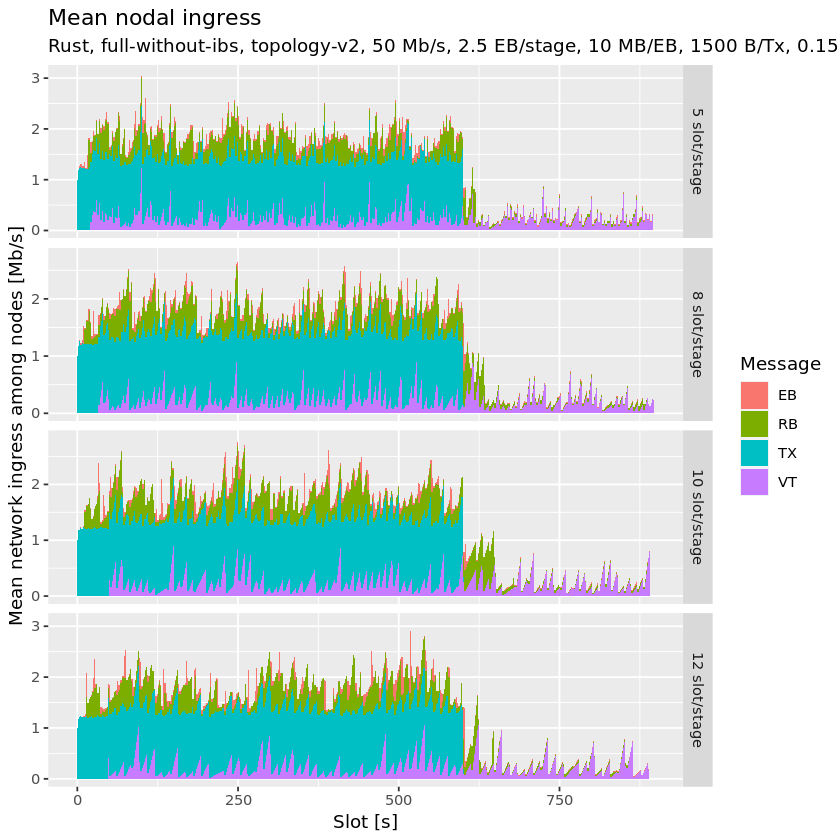

In [50]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    scales="free_y",
    outfiles=paste0("plots/ingress-average-area.png")
)

In [51]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            rs[,
                .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
                by=.(`Varied`, `Network`, `Slot`=floor(`Received [s]`), `Message`, `Recipient`)
            ][,
                .(`Size [Mb]`=max(`Size [Mb]`)),
                by=.(`Varied`, `Network`, `Slot`, `Message`)
            ],
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_varied(scales=scales) +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

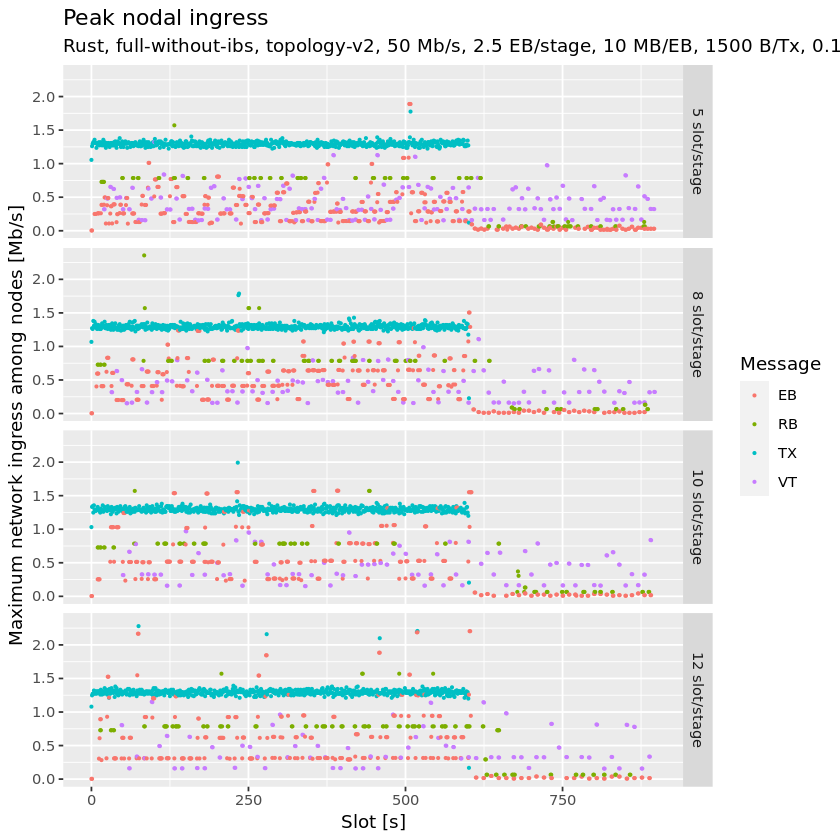

In [52]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/ingress-peak-point.png")
)

#### Release memory

In [53]:
rm(receipts)

In [54]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1121883,60.0,2158730,115.3,2158730,115.3
Vcells,2888353766,22036.4,7781005850,59364.4,9726214376,74205.2


### CPU usage

#### Read results

In [55]:
if (file.exists("results/cpus.Rdata")) {
    load(file="results/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(cpus, file="results/cpus.Rdata")
}
cpus[, `Stage length`:=factor(`Stage length`, levels=sort_factors(cpus[, unique(`Stage length`)]))]
cpus %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator                    Variant                 Network         
 Rust:337564523   full-without-ibs:337564523   topology-v2:337564523  
                                                                      
                                                                      
                                                                      
                                                                      
                                                                      
                                                                      
   Bandwidth                Stage length               EB rate         
 50 Mb/s:337564523   5 slot/stage :104594752   2.5 EB/stage:337564523  
                     8 slot/stage : 84113319                           
                     10 slot/stage: 76125380                           
                     12 slot/stage: 72731072                           
                                                                       


In [56]:
cpusNode <-
    substitute(
        cpus[
            ,
            .(`Duration [s]`=sum(`Duration [s]`)),
            by=.(`Varied`, `Network`, `Node`, `Slot`)
        ],
        env=list(`Varied`=sym(varied))
    ) %>% eval

In [57]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [58]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            cs[,
                .(`Duration [%]`=100*max(`Duration [s]`)),
                by=.(`Varied`, `Network`, `Slot`)
            ], 
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_varied(scales=scales) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

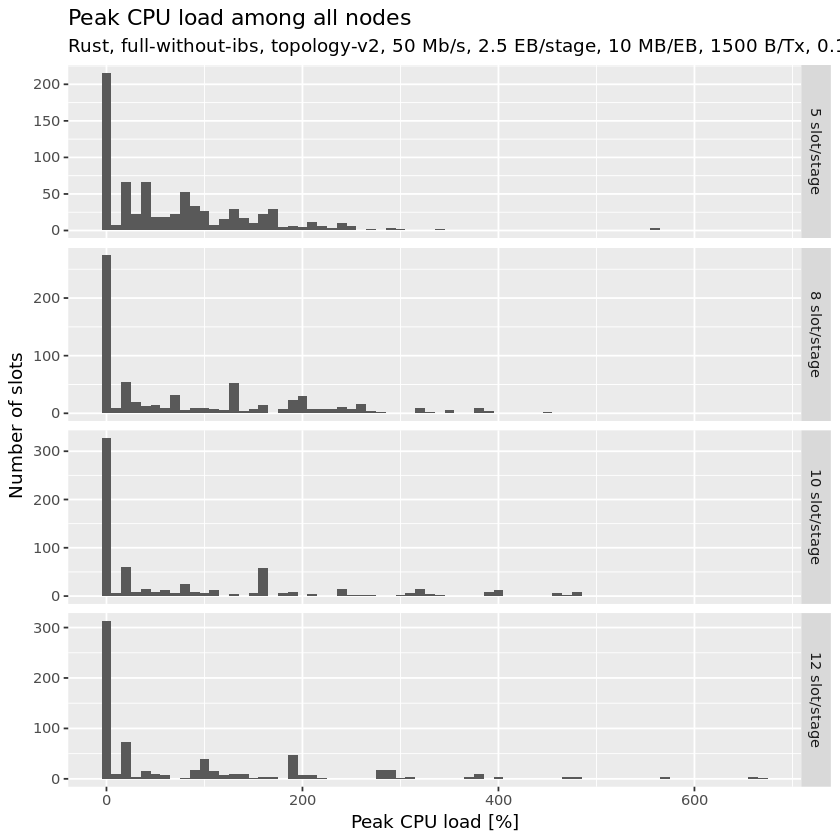

In [59]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/cpu-peak-histogram.png")
)

##### Time series

In [60]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            cs[,
                .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
                by=.(`Varied`, `Network`, `Slot`)
            ], 
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_varied(scale=scales) +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

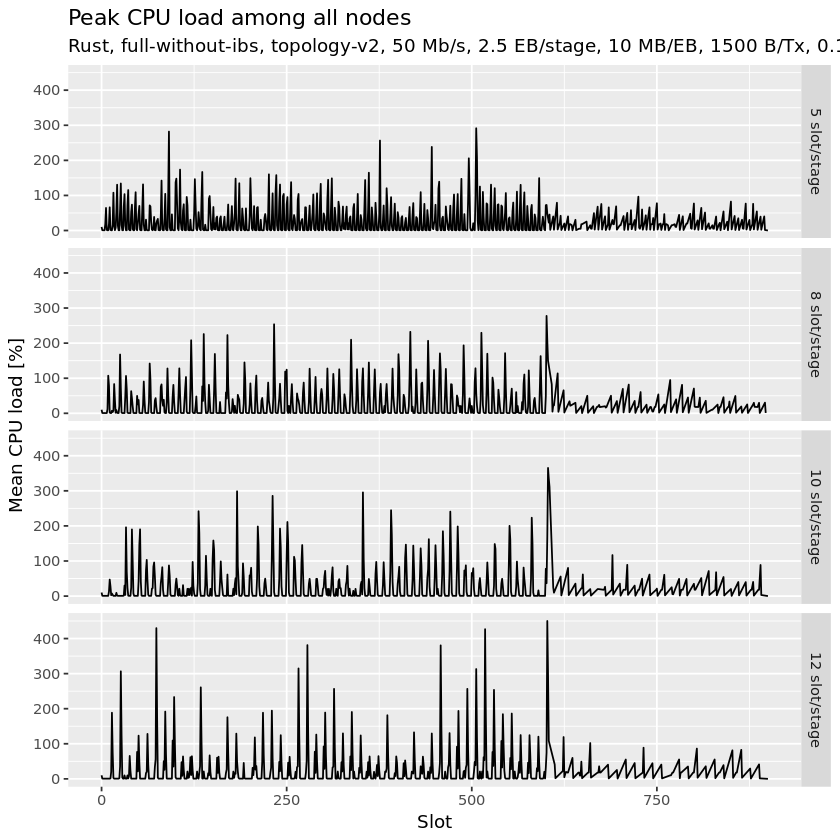

In [61]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [62]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/ifelse(`Network` == "topology-v1", 10000, 750)),
                by=.(`Varied`, `Network`, `Task`)
            ], 
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_varied(wide=TRUE, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

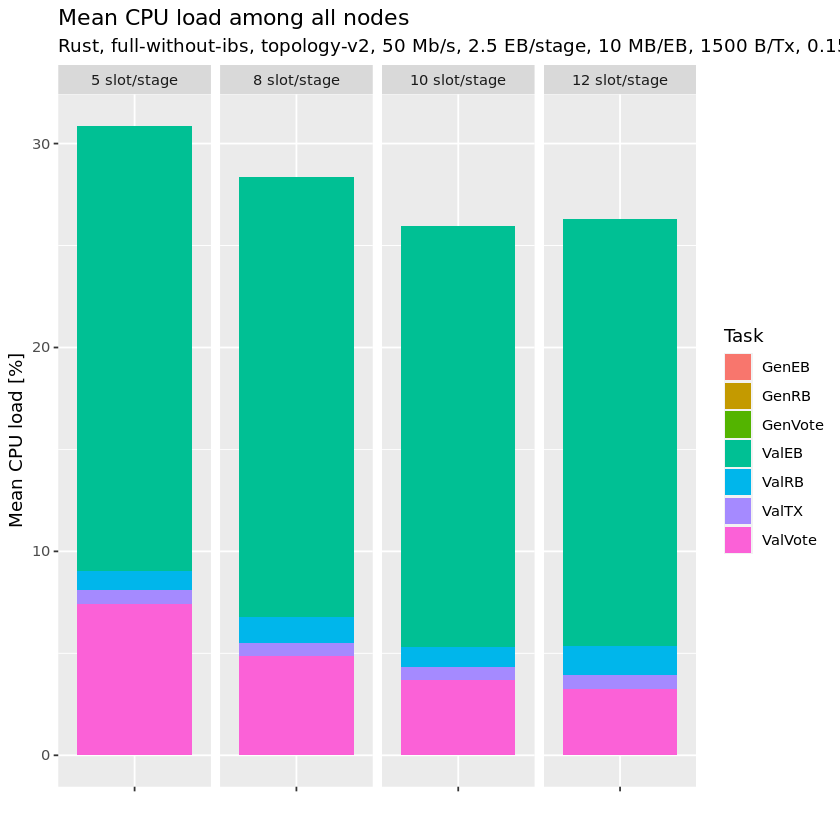

In [63]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/cpu-mean-histogram.png")
)

##### Time series

In [64]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        substitute(
            cs[,
                .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds/ifelse(`Network`=="topology-v1",10000,750)/sampleSize),
                by=.(`Varied`, `Network`, `Slot`, `Task`)
            ], 
            env=list(`Varied`=sym(varied))
        ) %>% eval,
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_varied(scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

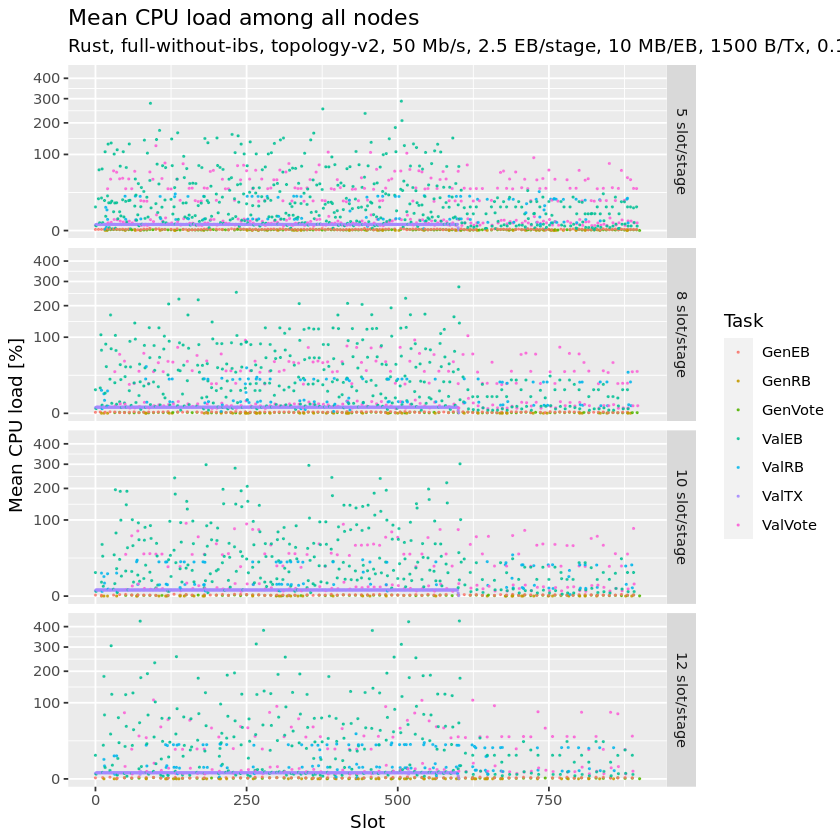

In [65]:
meanCpuTimeseries(
    cpus, 
    sampleSize, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cpu-mean-timeseries.png")
)

#### Release memory

In [66]:
rm(cpus, cpusNode)

In [67]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1011950,54.1,2158730,115.3,2158730,115.3
Vcells,2871242900,21905.9,9337287020,71237.9,9726214376,74205.2


## Block contents

### Read data

In [68]:
sizes <- fread("results/sizes.csv.gz", stringsAsFactors=TRUE)
setnames(sizes, old="Kind", new="Message")
sizes[, `Stage length`:=factor(`Stage length`, levels=sort_factors(sizes[, unique(`Stage length`)]))]
sizes %>% summary

 Simulator               Variant            Network       Bandwidth   
 Rust:1317   full-without-ibs:1317   topology-v2:1317   50 Mb/s:1317  
                                                                      
                                                                      
                                                                      
                                                                      
                                                                      
                                                                      
        Stage length         EB rate       Max EB size        Tx size    
 5 slot/stage :466   2.5 EB/stage:1317   10 MB/EB:1317   1500 B/Tx:1317  
 8 slot/stage :326                                                       
 10 slot/stage:266                                                       
 12 slot/stage:259                                                       
                                                              

### EB contents

#### Transactions

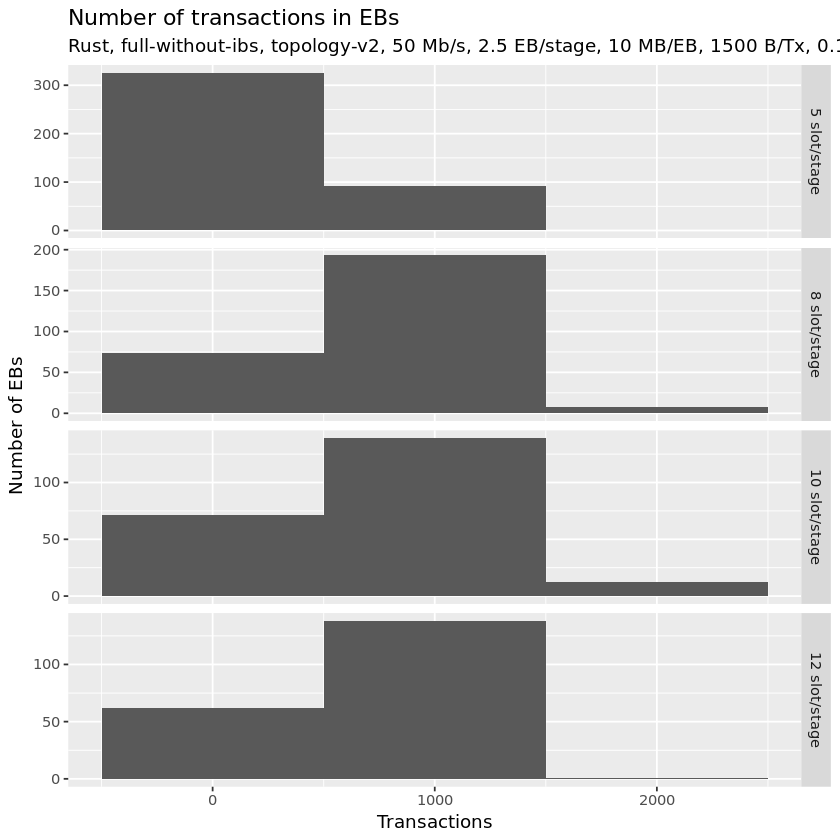

In [69]:
ggplot(sizes[`Message` == "EB"], aes(x=`Transactions`)) +
    geom_histogram(binwidth=1000) +
    facet_varied() +
    ylab("Number of EBs") +
    ggtitle("Number of transactions in EBs", label)

In [70]:
ggsave("plots/contents-ebs-txs.png", units="in", dpi=150, width=16, height=8)

#### Sizes

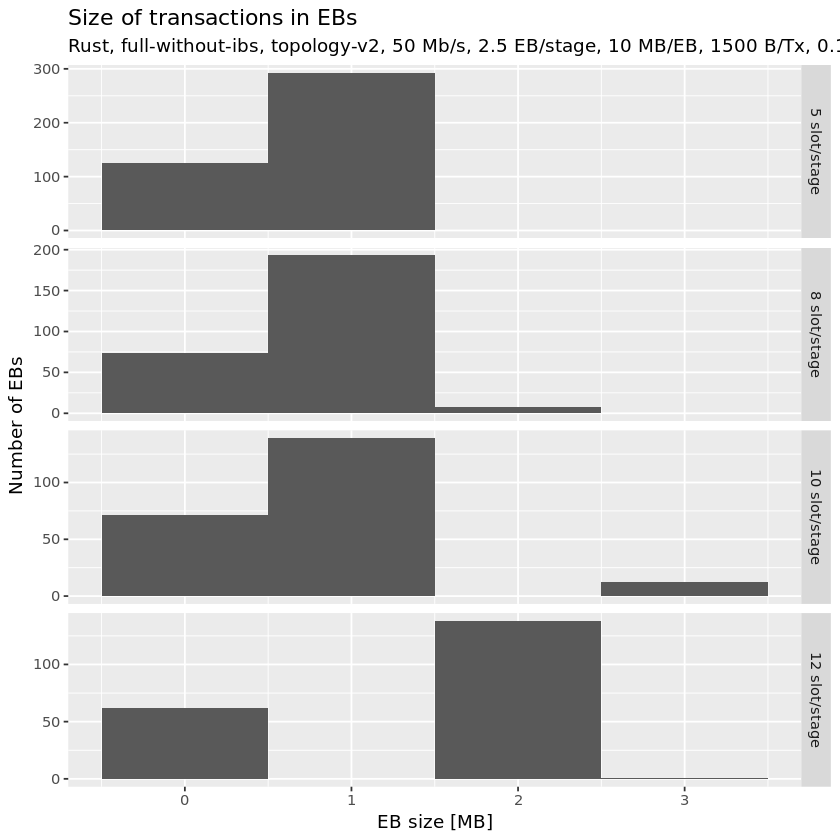

In [71]:
ggplot(
    substitute(
        sizes[`Message` == "EB", .(`EB size [MB]`=`Transactions`*1400/1e6), .(`Varied`, `Network`)], 
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x=`EB size [MB]`)
) +
    geom_histogram(binwidth=1) +
    facet_varied() +
    ylab("Number of EBs") +
    ggtitle("Size of transactions in EBs", label)

In [72]:
ggsave("plots/contents-ebs-size.png", units="in", dpi=150, width=16, height=8)

### RB contents

#### Transactions

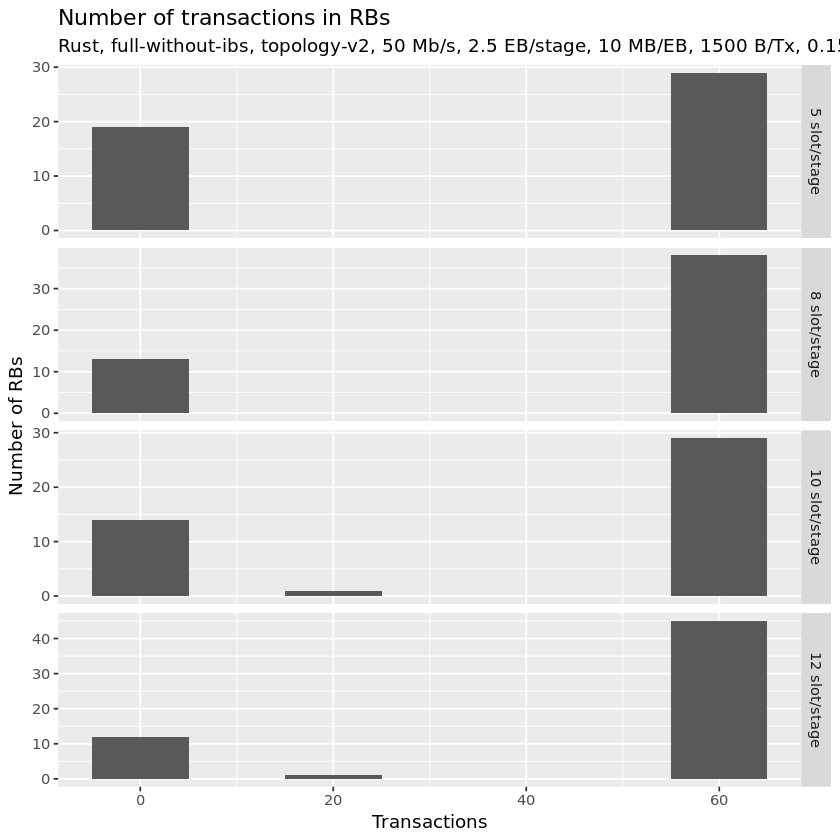

In [73]:
ggplot(sizes[`Message` == "RB"], aes(x=`Transactions`)) +
    geom_histogram(binwidth=10) +
    facet_varied() +
    ylab("Number of RBs") +
    ggtitle("Number of transactions in RBs", label)

In [74]:
ggsave("plots/contents-rbs-txs.png", units="in", dpi=150, width=16, height=8)

#### Sizes

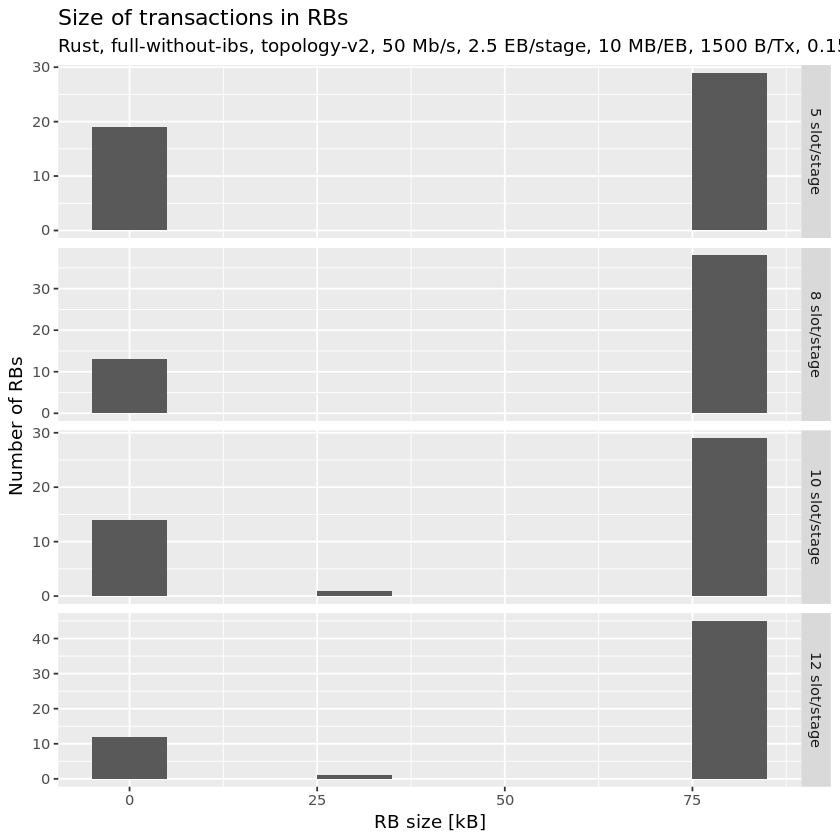

In [75]:
ggplot(
    substitute(
        sizes[`Message` == "RB", .(`RB size [kB]`=`Transactions`*1400/1e3), .(`Varied`, `Network`)],
        env=list(`Varied`=sym(varied))
    ) %>% eval,
    aes(x=`RB size [kB]`)
) +
    geom_histogram(binwidth=10) +
    facet_varied() +
    ylab("Number of RBs") +
    ggtitle("Size of transactions in RBs", label)

In [76]:
ggsave("plots/contents-rbs-size.png", units="in", dpi=150, width=16, height=8)